In [210]:
# imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr


## Data preprocessing

### Import

In [244]:
movie_df = pd.read_csv("../oscar_movies.csv")
movie_df

,year,movie,movie_id,certificate,duration,genre,rate,metascore,synopsis,votes,...,New_York_Film_Critics_Circle_nominated,New_York_Film_Critics_Circle_nominated_categories,Los_Angeles_Film_Critics_Association_won,Los_Angeles_Film_Critics_Association_won_categories,Los_Angeles_Film_Critics_Association_nominated,Los_Angeles_Film_Critics_Association_nominated_categories,release_date.year,release_date.month,release_date.day-of-month,release_date.day-of-week
0,2001,Kate & Leopold,tt0035423,PG-13,118,Comedy|Fantasy|Romance,6.4,44.0,An English Duke from 1876 is inadvertedly drag...,66660,...,0,NaN,0,NaN,0,NaN,2001.0,12.0,25.0,2.0
1,2000,Chicken Run,tt0120630,G,84,Animation|Adventure|Comedy,7.0,88.0,When a cockerel apparently flies into a chicke...,144475,...,1,Best Animated Film,1,Best Animation,1,Best Animation,2000.0,6.0,23.0,5.0
2,2005,Fantastic Four,tt0120667,PG-13,106,Action|Adventure|Family,5.7,40.0,A group of astronauts gain superpowers after a...,273203,...,0,NaN,0,NaN,0,NaN,2005.0,7.0,8.0,5.0
3,2002,Frida,tt0120679,R,123,Biography|Drama|Romance,7.4,61.0,"A biography of artist Frida Kahlo, who channel...",63852,...,0,NaN,0,NaN,0,NaN,2002.0,11.0,22.0,5.0
4,2001,The Lord of the Rings: The Fellowship of the Ring,tt0120737,PG-13,178,Adventure|Drama|Fantasy,8.8,92.0,A meek Hobbit from the Shire and eight compani...,1286275,...,0,NaN,1,Best Music,2,Best Music|Best Production Design,2001.0,12.0,19.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,2017,Call Me by Your Name,tt5726616,R,132,Drama|Romance,8.3,93.0,"In Northern Italy in 1983, seventeen year-old ...",38170,...,1,Best Actor,3,Best Actor|Best Director|Best Picture,3,Best Actor|Best Director|Best Picture,NaN,NaN,NaN,NaN
1179,2017,Phantom Thread,tt5776858,R,130,Drama|Romance,8.4,90.0,"Set in 1950's London, Reynolds Woodcock is a r...",7380,...,1,Best Screenplay,1,Best Music,1,Best Music,NaN,NaN,NaN,NaN
1180,2017,Victoria & Abdul,tt5816682,PG-13,111,Biography|Drama|History,6.8,58.0,Queen Victoria strikes up an unlikely friendsh...,12888,...,0,NaN,0,NaN,0,NaN,2017.0,10.0,6.0,5.0
1181,2017,"Roman J. Israel, Esq.",tt6000478,PG-13,122,Crime|Drama,6.3,58.0,"Roman J. Israel, Esq., a driven, idealistic de...",3205,...,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN


### Process

Basic check to make sure IDs are unique, since movies can very much so have the same name (as shown).

In [245]:
# make sure all IDs are unique

assert len(movie_df[movie_df.duplicated()]) == 0 

movie_df[movie_df.duplicated("movie", keep=False)] # this is OK, they are real movies with the same titles. 

,year,movie,movie_id,certificate,duration,genre,rate,metascore,synopsis,votes,...,New_York_Film_Critics_Circle_nominated,New_York_Film_Critics_Circle_nominated_categories,Los_Angeles_Film_Critics_Association_won,Los_Angeles_Film_Critics_Association_won_categories,Los_Angeles_Film_Critics_Association_nominated,Los_Angeles_Film_Critics_Association_nominated_categories,release_date.year,release_date.month,release_date.day-of-month,release_date.day-of-week
484,2006,The Illusionist,tt0443543,PG-13,110,Drama|Mystery|Romance,7.6,68.0,"In turn-of-the-century Vienna, a magician uses...",304063,...,0,NaN,0,NaN,0,NaN,2006.0,9.0,1.0,5.0
588,2010,The Illusionist,tt0775489,PG,80,Animation|Drama,7.5,82.0,A French illusionist finds himself out of work...,29236,...,1,Best Animated Film,0,NaN,1,Best Animation,2011.0,2.0,11.0,5.0


Oscar category wins have their own columns with "Yes" or "No" flags.
These flags should be booleans. 

In [246]:
# convert Oscar flags to boolean instead of "Yes", "No" (all starting with "Oscar_" except "Oscar_nominated","Oscar_nominated_categories")
for column in movie_df.columns:
    # get relevant Oscar flag columns
    if column.startswith("Oscar_") and column not in ["Oscar_nominated", "Oscar_nominated_categories"]:
        movie_df[column] = movie_df[column].replace({"Yes": True, "No": False})

movie_df["Oscar_Best_Picture_won"].dtype

dtype('bool')

Metascore (metacritic score) is an integer. But the `"metascore"` column is a float! Fix that.

In [247]:
# convert metascore (which is an int) to int.
movie_df["metascore"] = pd.to_numeric(movie_df["metascore"], errors='coerce').astype('Int64')

movie_df[movie_df["metascore"].isna()][["movie"]] # 13 movies are missing metascores. Unpopular movies. 

,movie
88,Ken Park
272,Twin Sisters
348,The Room
380,As It Is in Heaven
450,Yesterday
474,The Queen
577,Beaufort
652,Unthinkable
669,"Angus, Thongs and Perfect Snogging"
700,Death Proof


Popularity is based on the date the movie was scraped. 1 is the most popular movie on IMDB of that time. 
There are several movies in this dataset without a popularity statistic. Because the score is based on when it was scraped, we cannot manually fill these in.

'Moana' being there suggests to me that it's probably not exclusively very unpopular movies.

In [248]:
print(sum(movie_df["popularity"].isna()))
print(movie_df[movie_df["popularity"].isna()][["movie"]])

119
                           movie
25             Nowhere in Africa
54                       Pollock
56                   Wonder Boys
64         Shadow of the Vampire
67                         Vatel
...                          ...
1116             A Monster Calls
1121                        Sing
1124                       Moana
1130       The Girl on the Train
1171  Jim: The James Foley Story

[119 rows x 1 columns]


Luckily, movies released before 2017's US & Canada box grosses have not changed much from then to now, so the stats can be manually filled in.

In [249]:
# fill in missing grosses manually
# grosses are found on IMDB's Gross US & Canada rounded to the nearest $10k

gross_fill_dict = { # manually built from IMDB website (imdb.com)
    'Lagaan: Once Upon a Time in India': 909043,
    # 'Ken Park': 0, (missing US & Canada data)
    'Zus & zo': 49468,
    'The Twilight Samurai': 559765,
    'The Room': 549602,
    # 'Yesterday': 0, (missing US & Canada data)
    # 'Unthinkable': 0, (missing US & Canada data)
    # 'Angus, Thongs and Perfect Snogging': 0, (missing US & Canada data)
    # 'Death Proof': 0, (missing US & Canada data)
    # "Hachi: A Dog's Tale": 0, (missing US & Canada data)
    'Revanche': 258388,
    'Outside the Law': 96933,
    'Secret in Their Eyes': 20180155,
    'The Great Wall': 45540830,
    # 'Mudbound': 0, (missing US & Canada data)
    'Leviathan': 1092800,
    'Omar': 356000,
    'Trumbo': 7857741,
    'The Autopsy of Jane Doe': 10474,
    'Elle': 2341534,
    'Land of Mine': 435266,
    # 'The Girl with All the Gifts': 0, (missing US & Canada data)
    'Split': 138291365,
    # 'Jim: The James Foley Story': 0 (missing US & Canada data)
}
# round to $10k
gross_fill_dict = {key: round(value, -4) for key, value in gross_fill_dict.items()}


movie_df.loc[movie_df["gross"].isna(), "gross"] = movie_df["movie"].map(gross_fill_dict)

assert sum(movie_df["gross"].isna()) == 9

movie_df[movie_df["gross"].isna()][["year", "movie", "gross"]]

,year,movie,gross
88,2002,Ken Park,NaN
450,2004,Yesterday,NaN
652,2010,Unthinkable,NaN
669,2008,"Angus, Thongs and Perfect Snogging",NaN
700,2007,Death Proof,NaN
701,2009,Hachi: A Dog's Tale,NaN
1045,2017,Mudbound,NaN
1158,2016,The Girl with All the Gifts,NaN
1171,2016,Jim: The James Foley Story,NaN


Sanity check on votes.

In [250]:
print(sum(movie_df["votes"].isna()))

movie_with_most_votes = movie_df.loc[movie_df["votes"].idxmax(), "movie"]
movie_with_most_votes # The Dark Knight seems right.

0


'The Dark Knight'

#### Release dates

Make sure that missing `release_date` means missing `release_date.year`, `release_date.month`, `release_date.day-of-month`, and `release_date.day-of-week`. (It does!)

In [251]:
# check if missing release dates corresponds to missing release date specifics

no_release_date = movie_df["release_date"].isna()

no_year = (movie_df["release_date.year"].isna())
no_month = (movie_df["release_date.month"].isna())
no_day_month = (movie_df["release_date.day-of-month"].isna())
no_day_week = (movie_df["release_date.day-of-week"].isna())

# assert all refer to the same rows
assert ((no_release_date == no_year).all() 
        and (no_year == no_month).all() 
        and (no_month == no_day_month).all() 
        and (no_day_month == no_day_week).all())

# get movies without entered release dates
movie_df[movie_df["release_date"].isna()]["movie"]

1045                                     Mudbound
1060                                       Wonder
1165                                    Lady Bird
1169    Three Billboards Outside Ebbing, Missouri
1173                                     Marshall
1177                          The Florida Project
1178                         Call Me by Your Name
1179                               Phantom Thread
1181                        Roman J. Israel, Esq.
Name: movie, dtype: object

Go to datetime tipe for use later.

In [252]:
# convert "release_date" column to datetime types
movie_df["release_date"] = pd.to_datetime(movie_df["release_date"], dayfirst=False)

movie_df["release_date"].dtype
# dtype('<M8[ns]') is a datetype type

dtype('<M8[ns]')

Missing release dates are fixed manually using IMDB release dates to match the rest of the database. 

A movie's `"year"` is not its IMDB release date's year! It's the year for which the movie was awarded. This is why we have some movies with release date years in 2018. 

In [253]:
# fix missing release dates

movie_release_dict = {
    "Mudbound": pd.to_datetime("2017-11-17", yearfirst=True, dayfirst=False),
    "Wonder": pd.to_datetime("2017-11-17", yearfirst=True, dayfirst=False),
    "Lady Bird": pd.to_datetime("2017-12-1", yearfirst=True, dayfirst=False),
    "Three Billboards Outside Ebbing, Missouri": pd.to_datetime("2017-12-1", yearfirst=True, dayfirst=False),
    "Marshall": pd.to_datetime("2017-10-13", yearfirst=True, dayfirst=False),
    "The Florida Project": pd.to_datetime("2017-11-10", yearfirst=True, dayfirst=False),
    "Call Me by Your Name": pd.to_datetime("2018-1-19", yearfirst=True, dayfirst=False),
    "Phantom Thread": pd.to_datetime("2018-1-19", yearfirst=True, dayfirst=False),
    "Roman J. Israel, Esq.": pd.to_datetime("2017-11-22", yearfirst=True, dayfirst=False),
}

# fill missing release dates
no_release_date = movie_df["release_date"].isna()
movie_df.loc[no_release_date, "release_date"] = movie_df["movie"].map(movie_release_dict)

# Extract year, month, and day only for the rows in no_release_date
movie_df.loc[no_release_date, "release_date.year"] = movie_df["release_date"].dt.year
movie_df.loc[no_release_date, "release_date.month"] = movie_df["release_date"].dt.month
movie_df.loc[no_release_date, "release_date.day-of-month"] = movie_df["release_date"].dt.day

# NOTE: datetime package uses 0 as Monday, 6 as Sunday. CSV uses 1 as Monday and 7 as Sunday.  
# When adding new weekdays, *for now* we will use the CSV's form so when alignment with datetime happens they're all misaligned in the same way.
movie_df.loc[movie_df["release_date.day-of-week"].isna(), "release_date.day-of-week"] = movie_df["release_date"].dt.weekday + 1

# NOTE: A movie's `year` is not its IMDB (public) release date's year! It's the year for which the movie was awarded. This is why we have some movies with release date years in 2018. 
movie_df[no_release_date]["year"]

1045    2017
1060    2017
1165    2017
1169    2017
1173    2017
1177    2017
1178    2017
1179    2017
1181    2017
Name: year, dtype: int64

In [254]:
movie_df[ # convert "release_date.____" columns to ints instead of floats
    ["release_date.year", "release_date.month", "release_date.day-of-month", "release_date.day-of-week"]
    ] = movie_df[
        ["release_date.year", "release_date.month", "release_date.day-of-month", "release_date.day-of-week"]
        ].astype(int)
    
# align "release_date.day-of-week"
"""
0: mon
1: tues
2: wed
3: thurs
4: fri (most common)
5: sat
6: sun
"""

movie_df["release_date.day-of-week"] -= 1

In [255]:
# inspect manually
movie_df[["release_date", "release_date.year", "release_date.month", "release_date.day-of-month", "release_date.day-of-week"]]

,release_date,release_date.year,release_date.month,release_date.day-of-month,release_date.day-of-week
0,2001-12-25,2001,12,25,1
1,2000-06-23,2000,6,23,4
2,2005-07-08,2005,7,8,4
3,2002-11-22,2002,11,22,4
4,2001-12-19,2001,12,19,2
...,...,...,...,...,...
1178,2018-01-19,2018,1,19,4
1179,2018-01-19,2018,1,19,4
1180,2017-10-06,2017,10,6,4
1181,2017-11-22,2017,11,22,2


#### Make lists lists

`_categories` columns are originally delimited like this: `"Reward1|Reward2|Reward3"`.

Instead we want `["Reward1", "Reward2", "Reward3"]`

In [256]:
# convert "categories" nominated/won from "|"-delimited strings to lists of strings
for column in movie_df.columns:
    if "categories" in column:
        # convert to list if string, if already list then keep as list, otherwise empty list (no nominations)
        movie_df[column] = movie_df[column].apply(lambda entry: entry.split("|") if isinstance(entry, str) else (entry if isinstance(entry, list) else []))

# sanity check: make sure each entry length matches (for oscar at least)
oscar_mismatch_rows = movie_df[movie_df['Oscar_nominated_categories'].apply(len) != movie_df['Oscar_nominated']]
oscar_mismatch_rows[["Oscar_nominated_categories", "Oscar_nominated"]]

,Oscar_nominated_categories,Oscar_nominated


Do the same for `"genre"` which is delimited the same way.

In [257]:
# convert "genre" from "|"-delimited strings into lists of strings
assert movie_df["genre"].isna().sum() == 0 # luckily, every movie has a genre already

# convert to list if string, if already list then keep as list, otherwise empty list (should never happen)
movie_df["genre"] = movie_df["genre"].apply(lambda entry: entry.split("|") if isinstance(entry, str) else (entry if isinstance(entry, list) else []))

assert all (movie_df["genre"].apply(lambda x: len(x) > 0 and isinstance(x, list))) # confirm all entries still have a genre and that all are lists

movie_df["genre"]

0           [Comedy, Fantasy, Romance]
1       [Animation, Adventure, Comedy]
2          [Action, Adventure, Family]
3          [Biography, Drama, Romance]
4          [Adventure, Drama, Fantasy]
                     ...              
1178                  [Drama, Romance]
1179                  [Drama, Romance]
1180       [Biography, Drama, History]
1181                    [Crime, Drama]
1182       [Biography, Drama, History]
Name: genre, Length: 1183, dtype: object

Looks like there are no genres delimited-for that are not included.

In [258]:
movies_with_zero_length_genre_element = movie_df[movie_df["genre"].apply(lambda x: any(len(genre) == 0 for genre in x))]
movies_with_zero_length_genre_element

,year,movie,movie_id,certificate,duration,genre,rate,metascore,synopsis,votes,...,New_York_Film_Critics_Circle_nominated,New_York_Film_Critics_Circle_nominated_categories,Los_Angeles_Film_Critics_Association_won,Los_Angeles_Film_Critics_Association_won_categories,Los_Angeles_Film_Critics_Association_nominated,Los_Angeles_Film_Critics_Association_nominated_categories,release_date.year,release_date.month,release_date.day-of-month,release_date.day-of-week


#### Missing data

However, there are several entries missing in the `_categories` columns.
According to manual inspection, they are all in: 
- BAFTA, 
- LA Film Critics Association, 
- Austin Film Critics Association, and 
- Hollywood Film.

In [259]:
# Numerous '_categories' entries are missing. Too numerous to add manually.
# However, the '_won' and '_nominated' *non '_category'* columns appear accurate following manual investigation.

# Bafta
movies_with_zero_length_bafta_element = movie_df[movie_df["BAFTA_nominated_categories"].apply(lambda x: any(len(elem) == 0 for elem in x))]
movies_with_zero_length_bafta_element[["movie", "BAFTA_won", "BAFTA_won_categories", "BAFTA_nominated", "BAFTA_nominated_categories"]]
print(len(movies_with_zero_length_bafta_element))

# LAFC
movies_with_zero_length_lafc_element = movie_df[movie_df["Los_Angeles_Film_Critics_Association_nominated_categories"].apply(lambda x: any(len(elem) == 0 for elem in x))]
movies_with_zero_length_lafc_element[["movie", "Los_Angeles_Film_Critics_Association_won", "Los_Angeles_Film_Critics_Association_won_categories", "Los_Angeles_Film_Critics_Association_nominated", "Los_Angeles_Film_Critics_Association_nominated_categories"]]
print(len(movies_with_zero_length_lafc_element))

# Austin
movies_with_zero_length_austin_element = movie_df[movie_df["Austin_Film_Critics_Association_nominated_categories"].apply(lambda x: any(len(elem) == 0 for elem in x))]
movies_with_zero_length_austin_element[["movie", "Austin_Film_Critics_Association_won", "Austin_Film_Critics_Association_won_categories", "Austin_Film_Critics_Association_nominated", "Austin_Film_Critics_Association_nominated_categories"]]
print(len(movies_with_zero_length_austin_element))

# Hollywood
movies_with_zero_length_hollywood_element = movie_df[movie_df["Hollywood_Film_nominated_categories"].apply(lambda x: any(len(elem) == 0 for elem in x))]
movies_with_zero_length_hollywood_element[["movie", "Hollywood_Film_won", "Hollywood_Film_won_categories", "Hollywood_Film_nominated", "Hollywood_Film_nominated_categories"]]
print(len(movies_with_zero_length_hollywood_element))

103
6
12
9


Some movies are missing reviews and scores at time of scraping. Luckily, the number is quite small. 

**Un**luckily, we cannot fill in these stats now because more reviews definitely have come in since when this was scraped.

In [260]:
# movies without user reviews also have no critic reviews!
print(movie_df[movie_df["user_reviews"].isna()][["movie", "user_reviews"]]) # 7 missing
print(movie_df[movie_df["critic_reviews"].isna()][["movie", "critic_reviews"]]) # 7 missing

# ...
print(movie_df[movie_df["metascore"].isna()][["movie", "metascore"]]) # 14 missing, disjoint from previous group

                                        movie  user_reviews
574                     Letters from Iwo Jima           NaN
1094                                  Inferno           NaN
1104  Fantastic Beasts and Where to Find Them           NaN
1116                          A Monster Calls           NaN
1121                                     Sing           NaN
1124                                    Moana           NaN
1130                    The Girl on the Train           NaN
                                        movie  critic_reviews
574                     Letters from Iwo Jima             NaN
1094                                  Inferno             NaN
1104  Fantastic Beasts and Where to Find Them             NaN
1116                          A Monster Calls             NaN
1121                                     Sing             NaN
1124                                    Moana             NaN
1130                    The Girl on the Train             NaN
                        

Assign ratings to the 10 movies without ratings.

Only 8 are considered Not Rated (which means the movie was not submitted to MPAA)

The remaining two are not classified as such, so will remain N/A.

In [261]:
# Manually assign ratings (luckily these are all considered "Not Rated".)
movie_df.loc[movie_df["movie_id"] == "tt0382330", "certificate"] = "Not Rated"
movie_df.loc[movie_df["movie_id"] == "tt0426578", "certificate"] = "Not Rated"
movie_df.loc[movie_df["movie_id"] == "tt0879843", "certificate"] = "Not Rated"
movie_df.loc[movie_df["movie_id"] == "tt1077262", "certificate"] = "Not Rated"
movie_df.loc[movie_df["movie_id"] == "tt1337193", "certificate"] = "Not Rated"
movie_df.loc[movie_df["movie_id"] == "tt2852406", "certificate"] = "Not Rated"
movie_df.loc[movie_df["movie_id"] == "tt3170902", "certificate"] = "Not Rated"
movie_df.loc[movie_df["movie_id"] == "tt4239726", "certificate"] = "Not Rated"

movie_df[movie_df["certificate"].isna()][["movie", "movie_id", "year", "certificate"]]

# Twilight Samurai and Milk of Sorrow are not classified as "Not Rated", their rating truly does not exist.


,movie,movie_id,year,certificate
319,The Twilight Samurai,tt0351817,2002,NaN
766,The Milk of Sorrow,tt1206488,2009,NaN


### Summary Stats

In [262]:
movie_df.describe()

,year,duration,rate,metascore,votes,gross,user_reviews,critic_reviews,popularity,awards_wins,...,Boston_Society_of_Film_Critics_won,Boston_Society_of_Film_Critics_nominated,New_York_Film_Critics_Circle_won,New_York_Film_Critics_Circle_nominated,Los_Angeles_Film_Critics_Association_won,Los_Angeles_Film_Critics_Association_nominated,release_date.year,release_date.month,release_date.day-of-month,release_date.day-of-week
count,1183.000000,1183.000000,1183.000000,1169.0,1.183000e+03,1.174000e+03,1176.000000,1176.000000,1064.000000,1183.000000,...,1183.000000,1183.000000,1183.000000,1183.000000,1183.000000,1183.00000,1183.000000,1183.000000,1183.000000,1183.000000
mean,2008.189349,116.176669,7.045478,63.744226,1.925260e+05,8.518425e+07,568.876701,269.219388,1296.877820,2.894336,...,0.165680,0.319527,0.146238,0.313609,0.180051,0.32967,2008.389687,6.754015,16.015216,3.699915
std,5.019049,19.615381,0.826094,16.9733,1.912311e+05,1.009022e+08,564.816928,144.088080,1019.818482,6.237800,...,0.582839,0.886646,0.513523,0.841324,0.574890,0.89340,5.019872,3.703181,8.320552,0.744108
min,2000.000000,70.000000,2.400000,9.0,5.070000e+02,1.207000e+03,3.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2000.000000,1.000000,1.000000,0.000000
25%,2004.000000,102.000000,6.600000,51.0,6.550700e+04,1.509500e+07,219.000000,165.000000,524.750000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2004.000000,3.000000,9.000000,4.000000
50%,2008.000000,114.000000,7.100000,65.0,1.402320e+05,5.194000e+07,408.000000,239.000000,1088.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2008.000000,7.000000,16.000000,4.000000
75%,2013.000000,128.000000,7.600000,77.0,2.631190e+05,1.185900e+08,709.750000,351.000000,1772.750000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2013.000000,10.000000,23.000000,4.000000
max,2017.000000,224.000000,9.000000,100.0,1.743331e+06,9.366300e+08,5078.000000,816.000000,4937.000000,49.000000,...,5.000000,6.000000,5.000000,6.000000,5.000000,7.00000,2018.000000,12.000000,31.000000,6.000000


Number of movies, number of columns:

In [263]:
print(f"DIMENSIONS: {len(movie_df)} rows by {len(movie_df.columns)} columns")

DIMENSIONS: 1183 rows by 119 columns


## Investigations:

### Investigation 1

In [231]:
investigation2_movie_df = movie_df.copy()

0. Basic Data Summary and Exploration
To analyze the main characteristics of the dataset, we check the distribution of movie ratings.


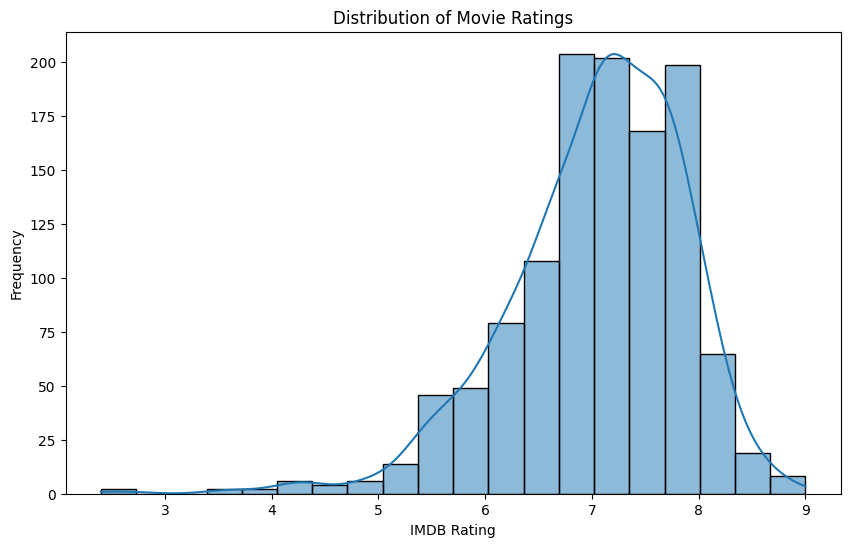

In [232]:
print("0. Basic Data Summary and Exploration")
print("To analyze the main characteristics of the dataset, we check the distribution of movie ratings.")
plt.figure(figsize=(10, 6))
sns.histplot(investigation2_movie_df['rate'], bins=20, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('IMDB Rating')
plt.ylabel('Frequency')
plt.show()

In [233]:
print("1. Basic Summary Statistics: Oscar-nominated vs Non-Oscar-nominated Movies\n")
oscar_nom = investigation2_movie_df[movie_df['Oscar_nominated'] > 0]['rate']
non_oscar_nom = investigation2_movie_df[movie_df['Oscar_nominated'] == 0]['rate']

print("Summary Statistics for Oscar-Nominated Movies:")
print(oscar_nom.describe())
print("\nSummary Statistics for Non-Oscar-Nominated Movies:")
print(non_oscar_nom.describe())

print("\nWe see there is a near-even split in the data, with the Oscar-nominated movies having a generally higher rating.")

1. Basic Summary Statistics: Oscar-nominated vs Non-Oscar-nominated Movies

Summary Statistics for Oscar-Nominated Movies:
count    632.000000
mean       7.419462
std        0.632694
min        4.000000
25%        7.100000
50%        7.500000
75%        7.800000
max        9.000000
Name: rate, dtype: float64

Summary Statistics for Non-Oscar-Nominated Movies:
count    551.000000
mean       6.616515
std        0.813812
min        2.400000
25%        6.200000
50%        6.700000
75%        7.100000
max        8.500000
Name: rate, dtype: float64

We see there is a near-even split in the data, with the Oscar-nominated movies having a generally higher rating.


2. Visualization: Distribution of IMDB Ratings (Oscar-Nominated vs Non-Nominated)


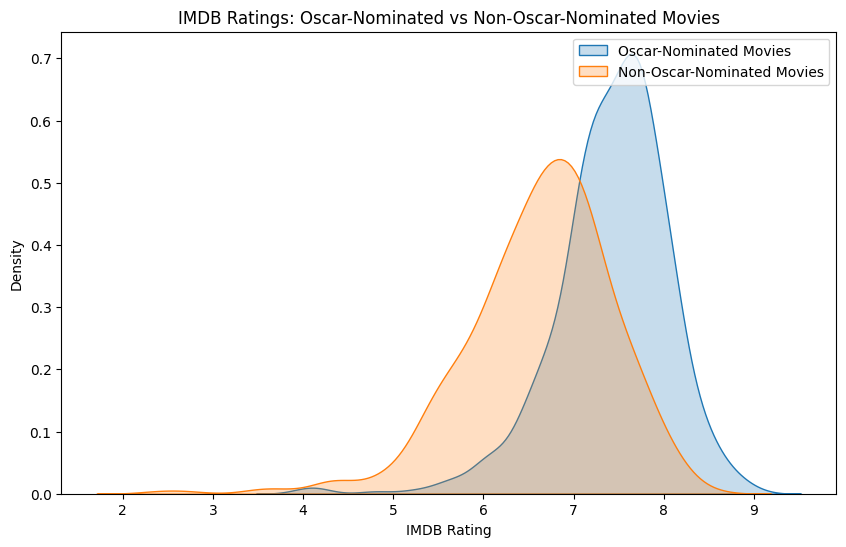

In [234]:
print("2. Visualization: Distribution of IMDB Ratings (Oscar-Nominated vs Non-Nominated)")
plt.figure(figsize=(10, 6))
sns.kdeplot(oscar_nom, label='Oscar-Nominated Movies', fill=True)
sns.kdeplot(non_oscar_nom, label='Non-Oscar-Nominated Movies', fill=True)
plt.title('IMDB Ratings: Oscar-Nominated vs Non-Oscar-Nominated Movies')
plt.xlabel('IMDB Rating')
plt.ylabel('Density')
plt.legend()
plt.show()

In [235]:
#For the future plots, it will be easier to create a column in the movie_df that has true if Oscar_nominated>0 and false otherwise
investigation2_movie_df['Oscar_nominations'] = investigation2_movie_df['Oscar_nominated'] > 0
display(investigation2_movie_df[['Oscar_nominated', 'Oscar_nominations']])

,Oscar_nominated,Oscar_nominations
0,1,True
1,0,False
2,0,False
3,6,True
4,13,True
...,...,...
1178,4,True
1179,6,True
1180,2,True
1181,1,True


3. Boxplot Comparison: IMDB Ratings (Oscar-Nominated vs Non-Nominated)


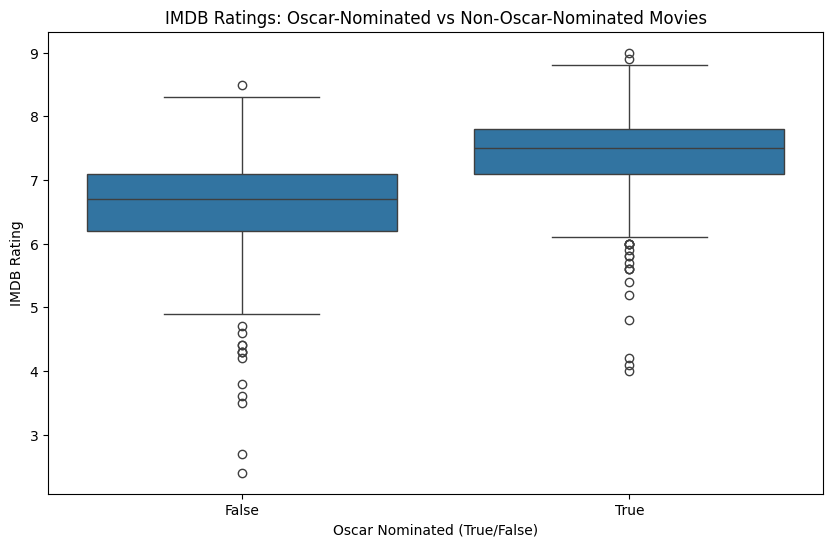

In [236]:
print("3. Boxplot Comparison: IMDB Ratings (Oscar-Nominated vs Non-Nominated)")
plt.figure(figsize=(10, 6))
sns.boxplot(x='Oscar_nominations', y='rate', data=investigation2_movie_df)
plt.title('IMDB Ratings: Oscar-Nominated vs Non-Oscar-Nominated Movies')
plt.xlabel('Oscar Nominated (True/False)')
plt.ylabel('IMDB Rating')
plt.show()

In [237]:
print("4. Hypothesis Testing: T-test to compare the means of the two groups\n")
t_stat, p_val = stats.ttest_ind(oscar_nom, non_oscar_nom, nan_policy='omit')

print(f"T-statistic: {t_stat}, P-value: {p_val}")

if p_val < 0.05:
    print("There is a statistically significant difference in ratings between Oscar-Nominated and non-Oscar-Nominated movies.")
else:
    print("There is no statistically significant difference in ratings between Oscar-Nominated and non-Oscar-Nominated movies.")

4. Hypothesis Testing: T-test to compare the means of the two groups

T-statistic: 19.061790129051214, P-value: 7.720598697773763e-71
There is a statistically significant difference in ratings between Oscar-Nominated and non-Oscar-Nominated movies.


5. Visualization: IMDB Rating Distribution by Oscar Wins


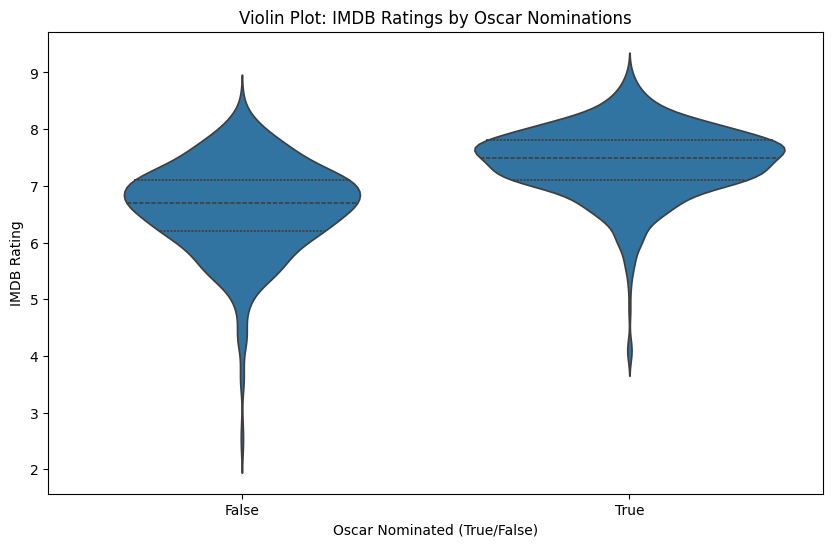

In [238]:
print("5. Visualization: IMDB Rating Distribution by Oscar Wins")
plt.figure(figsize=(10, 6))
sns.violinplot(x='Oscar_nominations', y='rate', data=investigation2_movie_df, inner='quartile')
plt.title('Violin Plot: IMDB Ratings by Oscar Nominations')
plt.xlabel('Oscar Nominated (True/False)')
plt.ylabel('IMDB Rating')
plt.show()

6. Additional Analysis: Does getting Nominated for an Oscar affect ratings in specific genres?
We'll analyze the relationship within the 'Drama' genre for better insights.


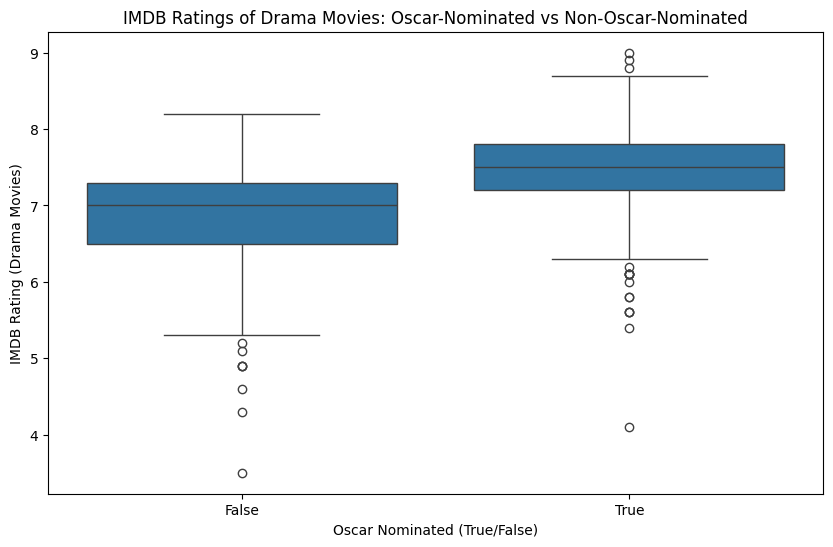

T-statistic (Drama Movies): 12.222206881793293, P-value (Drama Movies): 3.922383258659558e-31
There is a statistically significant difference in ratings for Drama movies between Oscar-Nominated and non-Oscar-Nominated movies.


In [240]:
print("6. Additional Analysis: Does getting Nominated for an Oscar affect ratings in specific genres?")
print("We'll analyze the relationship within the 'Drama' genre for better insights.")

drama_movies = investigation2_movie_df[investigation2_movie_df['genre'].apply(lambda genres: 'Drama' in genres)]

# Comparing IMDB ratings for drama movies that got 0 nominations vs those that got 1 or more nominations
oscar_nom_drama = drama_movies[drama_movies['Oscar_nominations'] == True]['rate']
non_oscar_nom_drama = drama_movies[drama_movies['Oscar_nominations'] == False]['rate']

# Plot comparison within the Drama genre
plt.figure(figsize=(10, 6))
sns.boxplot(x='Oscar_nominations', y='rate', data=drama_movies)
plt.title('IMDB Ratings of Drama Movies: Oscar-Nominated vs Non-Oscar-Nominated')
plt.xlabel('Oscar Nominated (True/False)')
plt.ylabel('IMDB Rating (Drama Movies)')
plt.show()

# Perform T-test for Drama movies
t_stat_drama, p_val_drama = stats.ttest_ind(oscar_nom_drama, non_oscar_nom_drama, nan_policy='omit')

print(f"T-statistic (Drama Movies): {t_stat_drama}, P-value (Drama Movies): {p_val_drama}")

if p_val_drama < 0.05:
    print("There is a statistically significant difference in ratings for Drama movies between Oscar-Nominated and non-Oscar-Nominated movies.")
else:
    print("There is no statistically significant difference in ratings for Drama movies between Oscar-Nominated and non-Oscar-Nominated movies.")

Key Conclusions:
1. Oscar-nominated movies tend to have higher IMDB ratings, as seen in both the density plot and boxplot.
2. Oscar nominations have a statistically significant impact on movie ratings, as confirmed by the T-test.
3. The violin plot further supports the trend of higher IMDB ratings for Oscar-nominated movies compared to non-nominated ones.
4. In the "Drama" genre, Oscar nominations also show a significant impact on ratings, suggesting that nomination prestige affects audience perception.

### Investigation 2

**First, let's determine if there are significant differences in gross profits among the movie certificates.**

*H0:* There are no significant differences in gross profits among the movie certificates.

*HA:* There are significant differences in gross profits among the movie certificates.

In [283]:
import matplotlib.ticker as ticker

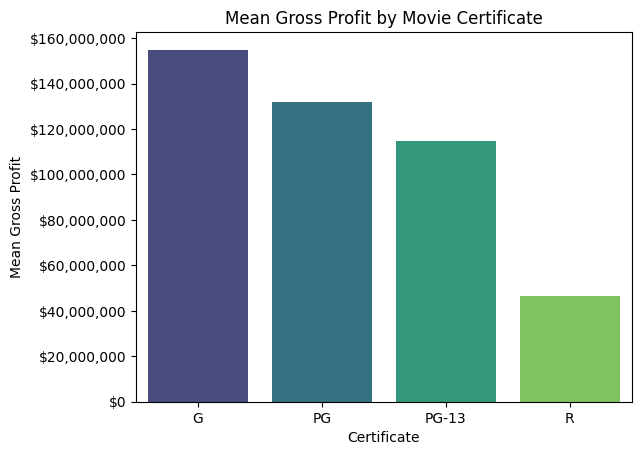

In [284]:
filtered_df = movie_df[movie_df['certificate'].isin(['G', 'PG', 'PG-13', 'R'])]
filtered_df = filtered_df.dropna(subset=['gross'])

mean_gross_by_certificate = filtered_df.groupby('certificate')['gross'].mean().reset_index()

plt.figure()
sns.barplot(x='certificate', y='gross', data=mean_gross_by_certificate, palette='viridis', hue='certificate', legend=False)

plt.xlabel('Certificate')
plt.ylabel('Mean Gross Profit')
plt.title('Mean Gross Profit by Movie Certificate')

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

plt.show()


**Performing an ANOVA Test to Find the p-value of the Hypothesis:**

In [ ]:
groups = [filtered_df[filtered_df['certificate'] == cert]['gross'].dropna() for cert in ['G', 'PG', 'PG-13', 'R']]
f_statistic, p_value = stats.f_oneway(*groups)

print(f'p-value: {p_value}')

**Conclusion: As the p-value is less than alpha (in this case, 0.05), we weject the null hypothesis; There are significant differences in gross profits among the movie certificates.**

*H0:* R-rated movies do not yield significantly less gross profit than other movie categories.

*HA:* R-rated movies yield significantly less gross profit than other movie categories.

In [287]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [289]:
tukey_result = pairwise_tukeyhsd(endog=filtered_df['gross'], groups=filtered_df['certificate'], alpha=0.05)

print(tukey_result)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
group1 group2     meandiff    p-adj       lower          upper      reject
--------------------------------------------------------------------------
     G     PG  -22991261.1356 0.7542  -82642137.5323  36659615.2611  False
     G  PG-13  -40022813.7608 0.2676  -96815111.4164  16769483.8948  False
     G      R -108163754.8717    0.0 -164908134.9033   -51419374.84   True
    PG  PG-13  -17031552.6252 0.2606  -41002479.1967   6939373.9464  False
    PG      R   -85172493.736    0.0 -109029671.1231  -61315316.349   True
 PG-13      R  -68140941.1109    0.0  -83513089.0084 -52768793.2133   True
--------------------------------------------------------------------------


Main Conclusion: 
- The Tukey HSD Test reveals that the p-adj values for each comparison made between R-rated films and other groups is less than alpha (0.05 in this case), so we reject the null hypothesis; R-rated movies yield significantly less gross profit than other movie categories.

### Investigation 3

In [266]:
movies = movie_df.copy()

In [268]:
# Dropping NaN to be able to perform Pearson
movies = movies[['duration', 'rate', 'metascore']].dropna()

# Pearson correlation for runtime vs rating
corr_rating, p_value_rating = pearsonr(movies['duration'], movies['rate'])

# Pearson correlation for runtime vs metascore
corr_metascore, p_value_metascore = pearsonr(movies['duration'], movies['metascore'])

print(f"Correlation between runtime and rating: {corr_rating}, p-value: {p_value_rating}")
print(f"Correlation between runtime and metascore: {corr_metascore}, p-value: {p_value_metascore}")

Correlation between runtime and rating: 0.28917156295091134, p-value: 5.94615651276181e-24
Correlation between runtime and metascore: 0.1587500374135552, p-value: 4.8534802753441075e-08


In [281]:
movies['metascore'] = movies['metascore'].astype('int64')

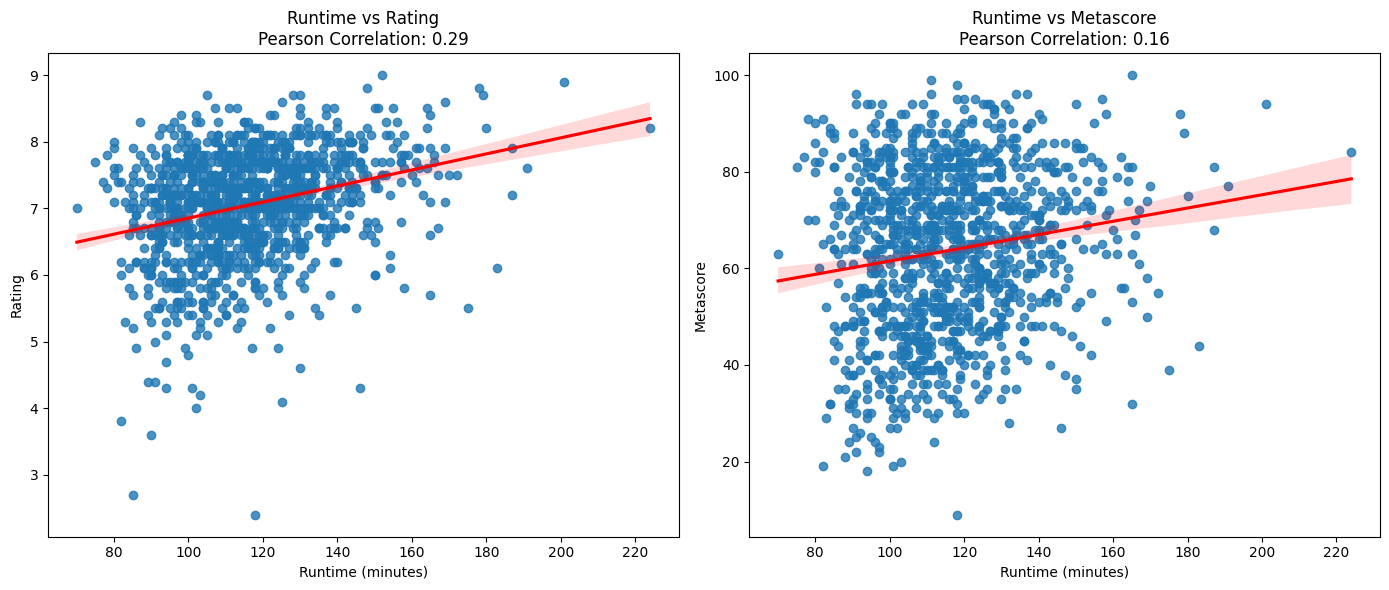

In [282]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Runtime vs Rating
sns.regplot(ax=axes[0], x='duration', y='rate', data=movies, scatter=True, line_kws={"color": "red"})
axes[0].set_title(f'Runtime vs Rating\nPearson Correlation: {corr_rating:.2f}')
axes[0].set_xlabel('Runtime (minutes)')
axes[0].set_ylabel('Rating')

# Plot 2: Runtime vs Metascore
sns.regplot(ax=axes[1], x='duration', y='metascore', data=movies, scatter=True, line_kws={"color": "red"})
axes[1].set_title(f'Runtime vs Metascore\nPearson Correlation: {corr_metascore:.2f}')
axes[1].set_xlabel('Runtime (minutes)')
axes[1].set_ylabel('Metascore')

plt.tight_layout()
plt.show()

Kwy Conclusions:
- Given the Pearson Correlation coefficient for Duration and Rate of 0.29 with an incredibly low p-value, there is some positive correlation between the two variables, albeit somewhat weak. With the plot and trendline, this notion is reinforced that there is some correlation between the rating and duration. 
- Looking at the Pearson Correlation coefficient for Duration and Metascore, there is a weak positive correlation between the two given the low coefficient. It is also weaker than the relationship between the rating as well. It is important to note the caveat that the range of choices for rating and metascore may be influencing this, as rating is able to cluster more given it can only be a number 1-10, while metascore can be a number 1-100. 
- Either way, given the Pearson correlation between Duration, Rate, and Metascore, there is some positive relationship that can be investigated further.